<a href="https://colab.research.google.com/github/LouisLortie/colab/blob/main/ecse_551_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title Import list

# from google.colab import drive                    # Need to activate this if using Google Colab (with drive)
import csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [21]:
#@title Load CSV

# drive.mount('/content/drive')                    # Activate on drive
# Reading air quality data
# aq_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/air_quality.csv")                 # Active on drive
aq_csv = pd.read_csv("air_quality.csv") 

# Reading liver patient data
# lp_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/liver_patient.csv")               # Active on drive
lp_csv = pd.read_csv("liver_patient.csv") 

# Array
aq_data = np.array(aq_csv)
lp_data = np.array(lp_csv)

In [121]:
#@title Setting rcParams
plt.style.use('classic')
plt.rcParams.update({
                        #  "text.usetex": True,
                        #  "font.family": "serif",
                        #  "font.sans-serif": ["Times"],
                         "lines.linewidth" : 3,
                         "font.size" : 12,
                         "figure.constrained_layout.use" : True,
                         "hist.bins" : 100 
                         })

In [227]:
#@title feature_count: Function that counts the number of features
def feature_count(data):
  return data.shape[1] - 1         # The last column is the class label

In [232]:
#@title data_separation: Function that separates the training data into the two binary classes
def data_separation(data):

  count_class1 = 0
  count_class0 = 0
  
  for i in range(data.shape[0]) :      # all rows of data

    if data[i, -1] == 0 :
      if count_class0 == 0 :
        data_class0 = data[[i], :]
      else :
        data_class0 = np.concatenate((data_class0, data[[i], :]), axis=0)
      count_class0 += 1

    elif data[i, -1] == 1 :
      if count_class1 == 0 :
        data_class1 = data[[i], :]
      else :
        data_class1 = np.concatenate((data_class1, data[[i], :]), axis=0)
      count_class1 += 1

  return data_class1, data_class0

In [238]:
#@title GenerativeLearning class: Generative model for binary classification

class GenerativeLearning:

  def __init__(self, data):
    self.data = data
    self.data_class1, self.data_class0 = data_separation(data)
    self.feat_count = feature_count(self.data)
    self.class1_count = self.data_class1.shape[0]
    self.class0_count = self.data_class0.shape[0]
    self.class1_prior = self.class1_count / self.data.shape[0]
    self.class0_prior = self.class0_count / self.data.shape[0]
    self.class1_mean = np.mean(self.data_class1[:,:-1], axis=0)
    self.class0_mean = np.mean(self.data_class0[:,:-1], axis=0)

    # Notice the difference in the covariance matrix calculation
    self.cov = ((self.data_class1[:,:-1] - self.class1_mean).T @ (self.data_class1[:,:-1] - self.class1_mean) + (self.data_class0[:,:-1] - self.class0_mean).T @ (self.data_class0[:,:-1] - self.class0_mean)) / (self.class1_count + self.class0_count - 2)
    self.cov_class1 = (self.data_class1[:,:-1] - self.class1_mean).T @ (self.data_class1[:,:-1] - self.class1_mean) / (self.class1_count - 1)
    self.cov_class0 = (self.data_class0[:,:-1] - self.class0_mean).T @ (self.data_class0[:,:-1] - self.class0_mean) / (self.class0_count - 1)
    

  def fit_lda_linear(self):

    self.w0 = np.log(self.class1_prior) - np.log(self.class0_prior) - 0.5 * self.class1_mean .T @ np.linalg.inv(self.cov) @ self.class1_mean + 0.5 * self.class0_mean .T @ np.linalg.inv(self.cov) @ self.class0_mean
    self.w1 = np.linalg.inv(self.cov) @ (self.class1_mean - self.class0_mean)
    self.w = np.concatenate((self.w0.reshape(1,), self.w1))

    return self.w


  def fit_lda_quadratic(self):      # Should be fine, but has not been tested out
      
      self.w0 = np.log(self.class1_prior) - np.log(self.class0_prior) - 0.5 * self.class1_mean .T @ np.linalg.inv(self.cov_class1) @ self.class1_mean + 0.5 * self.class0_mean .T @ np.linalg.inv(self.cov_class0) @ self.class0_mean - 0.5 * np.log(np.linalg.det(self.cov_class1)) + 0.5 * np.log(np.linalg.det(self.cov_class0))
      self.w1 = np.linalg.inv(self.cov_class1) @ self.class1_mean - np.linalg.inv(self.cov_class0) @ self.class0_mean
      self.w2 = -0.5 * np.linalg.inv(self.cov_class0) + 0.5 * np.linalg.inv(self.cov_class1)
      self.w = np.concatenate((self.w0.reshape(1,), self.w1, self.w2))
  
      return self.w


  def predict(self, x):

    self.y = x @ self.w[1:] + self.w[0]
    # print(self.y)
    
    return self.y


In [166]:
#@title augment_ones function: Function that augments the data with a column of ones
def augment_ones(data):
    ones = np.ones((data.shape[0], 1))
    return np.concatenate((data, ones), axis=1)

In [167]:
#@title increase_complexity function: Function that increases the complexity of the data

def increase_complexity(data):
    # data = augment_ones(data)                                    # could be used to augment the data with a column of ones
    data = np.concatenate((data, data[:, :-1]**2), axis=1)         # Here, we augment the data with a column of squares of the features
    return data

In [214]:
#@title fold_prep: Separates data into testing, validation and testing sets
def fold_prep(data, train_num, validation_num, test_num):
    # np.random.shuffle(data)
    data_train = data[:train_num, :]
    data_val = data[train_num:train_num+validation_num, :]
    data_test = data[train_num+validation_num:train_num+validation_num+test_num, :]
    return data_train, data_val, data_test

In [225]:
#@title plot hist: Function that plots the histogram of one feature
# The number of bins can be changed via rcParams above.

def plot_hist(feat_class1, feat_class0, feat_num):
  fig, ax = plt.subplots(2, 1, sharex=True)
  ax[0].hist(feat_class1, color="b", label=r"Class y = 1")
  ax[1].hist(feat_class0, color="r", label=r"Class y = 0")
  ax[0].set_title("Feature %i distribution comparison between classes" %(feat_num + 1))
  ax[0].legend(loc='upper right')
  ax[1].legend(loc='upper right')
  plt.tight_layout

  return 0

In [239]:
#@title prediction_line: Function that plots the regression line

# Cannot plot the regression because there are too many features. Would be fine with 2 features.

# This plot shows that if its above zero, it is classified as 1, and if its below zero, it is classified as 0.

def prediction_line(x_class1, x_class0, w): 
    
    x = (np.concatenate((x_class1, x_class0), axis=0)).reshape(-1, 1)
    
    fig, ax = plt.subplots(1, 1)
    y_class1 = x_class1 @ w[1:] + w[0]
    y_class0 = x_class0 @ w[1:] + w[0]
    range1 = np.linspace(np.min(x), np.max(x), y_class1.shape[0])
    range2 = np.linspace(np.min(x), np.max(x), y_class0.shape[0])

    ax.scatter(range1, y_class1, color="b", label=r"Class y = 1")
    ax.scatter(range2, y_class0, color="r", label=r"Class y = 0")
    ax.plot([np.min(x), np.max(x)], [0, 0], color="g")
    ax.set_title("Predictions")
    ax.legend(loc='upper right')
    plt.tight_layout
    
    return 0

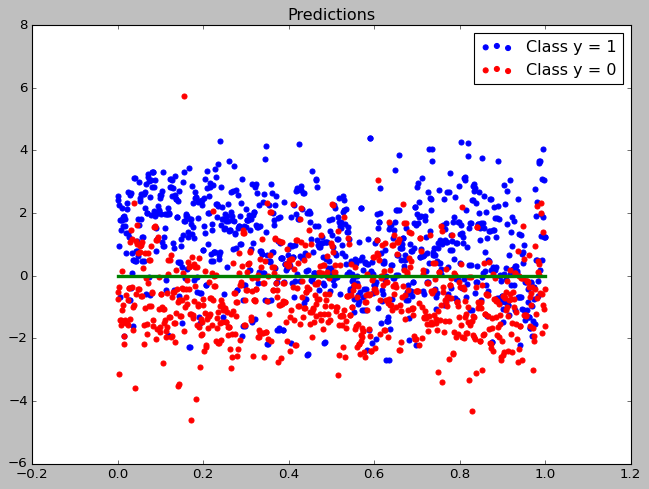

In [240]:
#@title Main function
def main():

  feat = 3   # Feature to analyse starting from 0
  
  # plot_hist(data_class1[:, feat], data_class0[:, feat], feat)
  
  model2 = GenerativeLearning(aq_data)
  
  w = model2.fit_lda_linear()
  model2.predict(aq_data[:, :-1])

  data_class1, data_class0 = data_separation(aq_data)

  
  prediction_line(model2.data_class1[:, :-1], model2.data_class0[:, :-1], model2.w)

  
  
if __name__ == '__main__':
    main()